In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Adjust path if necessary
df = pd.read_csv("../data/returns_and_characteristics.csv")

In [3]:
rows, cols = df.shape
print(f"Rows: {rows}, Columns: {cols}")

Rows: 842680, Columns: 98


In [4]:
years = df['year'].drop_duplicates().sort_values().values
years

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [5]:
num_permnos = df['permno'].nunique()
print(f"Number of unique permnos: {num_permnos}")

Number of unique permnos: 11397


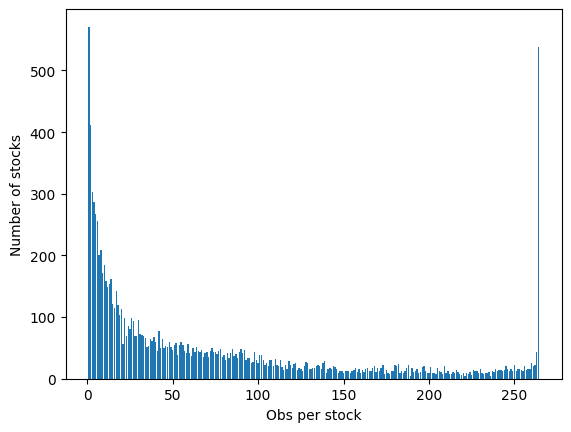

In [6]:
obs_per_stock = df.groupby('permno').size()

dist = obs_per_stock.value_counts().sort_index()

plt.figure()
plt.bar(dist.index, dist.values)
plt.xlabel('Obs per stock')
plt.ylabel('Number of stocks')
plt.show()

Data splitting

In [7]:
train_years = list(range(2000, 2017))  

df_train = df[df['year'].isin(train_years)].copy()
df_test  = df[~df['year'].isin(train_years)].copy()

print("Train years:", df_train['year'].drop_duplicates().sort_values().values)
print("Test years: ", df_test ['year'].drop_duplicates().sort_values().values)

Train years: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016]
Test years:  [2017 2018 2019 2020 2021]


Example of portfolio rule

Calculation of a single-period out-of-sample returns

In [ ]:
# 1. Get the list of stocks in the training data and set equal weights
train_permnos = df_train['permno'].unique()
n_train = len(train_permnos)
w = pd.Series(1.0/n_train, index=train_permnos, name='weight')

# 2. Identify the first test period
first_year  = df_test['year'].min()
first_month = df_test[df_test['year'] == first_year]['month'].min()
df_first = df_test[(df_test['year'] == first_year) & (df_test['month'] == first_month)]

# 3. Restrict weights to stocks in that test period, zero out the rest, and renormalize
w_test = w.reindex(df_first['permno'].unique(), fill_value=0)
w_test /= w_test.sum()

# 4. Compute the portfolio return in that month
df_first = df_first.set_index('permno')
port_return = (df_first['ret_monthly'] * w_test).sum()

print(f"Portfolio return for {first_month}/{first_year}: {port_return:.4%}")


Portfolio return for 1/2017: 2.3136%


Loop through all dates of the out-of-sample period

In [13]:
# 1. Compute the initial equal‐weight training portfolio
train_permnos = df_train['permno'].unique()
n_train = len(train_permnos)
w_init = pd.Series(1.0 / n_train, index=train_permnos, name='weight')

# 2. Build a list of test periods in chronological order
test_periods = (
    df_test[['year','month']]
    .drop_duplicates()
    .sort_values(['year','month'])
    .to_records(index=False)
)

# 3. Loop over each test period, zero‐out missing stocks, renormalize, and compute return
rets = []
dates = []
for year, month in test_periods:
    # select returns in this period
    df_per = df_test[(df_test['year']==year)&(df_test['month']==month)]
    # index by permno
    df_per = df_per.set_index('permno')
    # restrict & reindex the weight vector to this period’s universe
    w = w_init.reindex(df_per.index, fill_value=0)
    # renormalize so weights sum to 1
    w /= w.sum()
    # compute the portfolio return
    port_ret = (w * df_per['ret_monthly']).sum()
    rets.append(port_ret)
    dates.append(pd.to_datetime(f"{year}-{month}-01"))

# 4. Assemble into a pandas Series
portfolio_returns = pd.Series(data=rets, index=dates)
portfolio_returns.name = 'eqw_train_portfolio_ret'

# 5. (Optional) inspect
print(portfolio_returns.head())


2017-01-01    0.023136
2017-02-01    0.027976
2017-03-01    0.014534
2017-04-01    0.009038
2017-05-01   -0.009116
Name: eqw_train_portfolio_ret, dtype: float64


Performance metrics

In [16]:
# 1. Average (mean) monthly return
mean_ret = portfolio_returns.mean()

# 2. Standard deviation of monthly returns
std_ret = portfolio_returns.std()

# 3. Sharpe ratio (annualized, assuming 12 months per year and zero risk‐free rate)
sharpe_ratio = mean_ret / std_ret * np.sqrt(12)

# 4. (Optional) annualize the average return and volatility
annual_ret = mean_ret * 12
annual_vol = std_ret * np.sqrt(12)

print(f"Mean monthly return: {mean_ret:.4%}")
print(f"Monthly volatility: {std_ret:.4%}")
print(f"Annualized return: {annual_ret:.4%}")
print(f"Annualized volatility: {annual_vol:.4%}")
print(f"Annualized Sharpe ratio: {sharpe_ratio:.2f}")


Mean monthly return: 2.2197%
Monthly volatility: 6.2023%
Annualized return: 26.6360%
Annualized volatility: 21.4854%
Annualized Sharpe ratio: 1.24
